# ANÁLISE EXPLORATÓRIA DE DADOS (EDA)
### A Análise Exploratória de Dados (EDA - Exploratory Data Analysis) é uma abordagem inicial na ciência de dados usada para investigar, visualizar e resumir as principais características, padrões, anomalias e estruturas de um conjunto de dados.

OBJETIVO
- Carregar dados do SQLite
- Análise univariada (cada variável individualmente)
- Análise bivariada (relação com o target)
- Identificar padrões e insights
- Detectar outliers e anomalias
- Preparar para modelagem

PERGUNTAS QUE VAMOS RESPONDER:
- Como está distribuída a inadimplência?
- Quais características diferenciam adimplentes de inadimplentes?
- Há correlações importantes entre variáveis?
- Os dados estão balanceados?
- Há valores atípicos?

In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as stats
import warnings
warnings.filterwarnings('ignore')

# Config de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("="*80)
print("🔍 ANÁLISE EXPLORATÓRIA DE DADOS (EDA)")
print("="*80)

print("\n📂 CARREGANDO DADOS...")

# Conecta ao banco
DB_PATH = 'data/database.db'
print(f"\n📁 Conectando ao banco: {DB_PATH}")

conn = sqlite3.connect(DB_PATH)

df = pd.read_sql("SELECT * FROM clientes", conn)
conn.close()

print(f"✅ Dados carregados com sucesso!")
print(f"\n📊 Shape: {df.shape[0]:,} linhas × {df.shape[1]} colunas")

🔍 ANÁLISE EXPLORATÓRIA DE DADOS (EDA)

📂 CARREGANDO DADOS...

📁 Conectando ao banco: data/database.db
✅ Dados carregados com sucesso!

📊 Shape: 100,000 linhas × 17 colunas


In [12]:
from IPython.display import display

print("\n" + "="*80)
print("📋 1. VISÃO GERAL DOS DADOS")
print("="*80)

print("\n📊 Primeiras 5 linhas:")
display(df.head())

print("\n📊 Últimas 5 linhas:")
display(df.tail())

print("\n📊 Informações das colunas:")
df.info()

print("\n📊 Estatísticas descritivas (variáveis numéricas):")
display(df.describe().T)

# Seleciona apenas colunas categóricas
cat_df = df.select_dtypes(include=['object', 'category', 'bool'])

if not cat_df.empty:
    print("\n📊 Estatísticas descritivas (variáveis categóricas):")
    display(cat_df.describe().T)
else:
    print("\n⚠️ Não há variáveis categóricas no DataFrame.")



📋 1. VISÃO GERAL DOS DADOS

📊 Primeiras 5 linhas:


,id_cliente,idade,genero,estado_civil,escolaridade,estado,renda_anual,valor_patrimonio,possui_imovel_proprio,possui_carro,ocupacao,numero_dependentes,tempo_emprego_atual,score_serasa_externo,utilizacao_limite_cartao,historico_atraso_90_dias,inadimplente
0,1,47,M,Divorciado,Médio,RJ,9059.86,50709.30,1,0,CLT,2,316,698,11.50,0,0
1,2,37,F,Casado,Médio,PR,40713.82,140855.24,1,1,CLT,1,356,389,65.60,2,1
2,3,49,M,Casado,Médio,BA,72448.95,318428.40,1,1,CLT,3,358,428,0.00,0,0
3,4,62,F,Casado,Médio,SP,42668.42,98233.00,1,1,CLT,3,34,560,77.55,1,0
4,5,36,M,Casado,Superior,RS,46197.81,187751.14,0,1,Autônomo,1,290,475,41.52,0,0



📊 Últimas 5 linhas:


,id_cliente,idade,genero,estado_civil,escolaridade,estado,renda_anual,valor_patrimonio,possui_imovel_proprio,possui_carro,ocupacao,numero_dependentes,tempo_emprego_atual,score_serasa_externo,utilizacao_limite_cartao,historico_atraso_90_dias,inadimplente
99995,99996,36,M,Viúvo,Superior,CE,1952.05,48636.58,0,0,CLT,0,262,874,56.37,0,0
99996,99997,31,F,Casado,Superior,MG,8769.78,28972.85,0,1,Autônomo,0,107,770,30.33,2,0
99997,99998,46,F,Casado,Fundamental,GO,41869.29,149848.13,1,1,Desempregado,0,0,674,4.08,0,0
99998,99999,36,F,Casado,Médio,RJ,72596.31,298021.38,1,1,CLT,1,289,537,1.51,0,0
99999,100000,41,F,Casado,Superior,MG,63380.97,327709.99,1,0,CLT,2,109,528,19.14,0,0



📊 Informações das colunas:
<class 'pandas.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id_cliente                100000 non-null  int64  
 1   idade                     100000 non-null  int64  
 2   genero                    100000 non-null  str    
 3   estado_civil              100000 non-null  str    
 4   escolaridade              100000 non-null  str    
 5   estado                    100000 non-null  str    
 6   renda_anual               100000 non-null  float64
 7   valor_patrimonio          100000 non-null  float64
 8   possui_imovel_proprio     100000 non-null  int64  
 9   possui_carro              100000 non-null  int64  
 10  ocupacao                  100000 non-null  str    
 11  numero_dependentes        100000 non-null  int64  
 12  tempo_emprego_atual       100000 non-null  int64  
 13  score_serasa_externo      10

,count,mean,std,min,25%,50%,75%,max
id_cliente,100000.0,50000.500000,28867.657797,1.00,25000.7500,50000.50,75000.2500,100000.00
idade,100000.0,40.009880,13.992178,18.00,29.0000,40.00,50.0000,80.00
renda_anual,100000.0,45177.053202,43174.173904,689.83,19008.1050,32694.03,56266.1125,873983.11
valor_patrimonio,100000.0,215021.197379,260343.440356,6232.24,88587.5225,150690.92,259559.0450,22306417.25
possui_imovel_proprio,100000.0,0.485350,0.499788,0.00,0.0000,0.00,1.0000,1.00
possui_carro,100000.0,0.442090,0.496638,0.00,0.0000,0.00,1.0000,1.00
numero_dependentes,100000.0,1.447260,1.162253,0.00,0.0000,1.00,2.0000,4.00
tempo_emprego_atual,100000.0,171.020310,108.352768,0.00,76.0000,171.00,265.0000,359.00
score_serasa_externo,100000.0,599.104670,143.588663,300.00,498.0000,599.00,699.0000,900.00
utilizacao_limite_cartao,100000.0,40.490085,23.619094,0.00,23.0600,40.01,56.8700,100.00



📊 Estatísticas descritivas (variáveis categóricas):


,count,unique,top,freq
genero,100000,2,F,52229
estado_civil,100000,4,Casado,45068
escolaridade,100000,4,Médio,35102
estado,100000,10,SP,25007
ocupacao,100000,4,CLT,60113


In [ ]:
# Verificação de qualidade dos dados
print("\n" + "="*80)
print("📋 2. QUALIDADE DOS DADOS")
print("="*80)

print("\n🔍 Verificando valores nulos:")
nulos = df.isnull().sum()
if nulos.sum() == 0:
  print("✅ Não há valores nulos no dataset!")
else:
  print("⚠️ Valores nulos encontrados:")
  print(nulos[nulos > 0])

print("\n🔍 Verificando duplicatas:")
duplicatas = df.duplicated(subset=['id_cliente']).sum()
if duplicatas == 0:
  print("✅ Não há IDs duplicados!")
else:
  print(f"⚠️{duplicatas} IDs duplicados encontrados")

print("\n🔍 Verificando valores únicos por coluna:")
for col in df.columns:
  n_unique = df[col].nunique()
  print(f"{col:30s}: {n_unique:>6,} valores únicos")


📋 2. QUALIDADE DOS DADOS

🔍 Verificando valores nulos:
✅ Não há valores nulos no dataset!

🔍 Verificando duplicatas:
✅ Não há IDs duplicados!

🔍 Verificando valores únicos por coluna:
id_cliente                    : 100,000 valores únicos
idade                         :     63 valores únicos
genero                        :      2 valores únicos
estado_civil                  :      4 valores únicos
escolaridade                  :      4 valores únicos
estado                        :     10 valores únicos
renda_anual                   : 99,384 valores únicos
valor_patrimonio              : 99,849 valores únicos
possui_imovel_proprio         :      2 valores únicos
possui_carro                  :      2 valores únicos
ocupacao                      :      4 valores únicos
numero_dependentes            :      5 valores únicos
tempo_emprego_atual           :    360 valores únicos
score_serasa_externo          :    601 valores únicos
utilizacao_limite_cartao      :  9,700 valores únicos
hist

In [15]:
print("\n" + "="*80)
print("🎯 3. ANÁLISE DO TARGET (INADIMPLENTE)")
print("="*80)

print("\n📊 Distribuição do target")
distribuicao = df['inadimplente'].value_counts().sort_index()
for valor, qtd in distribuicao.items():
  label = 'Adimplente' if valor == 0 else 'Inadimplente'
  pct = qtd / len(df) * 100
  print(f"{label} ({valor}): {qtd:>7,} ({pct:>5.1f})%")


🎯 3. ANÁLISE DO TARGET (INADIMPLENTE)

📊 Distribuição do target
Adimplente (0):  80,797 ( 80.8)%
Inadimplente (1):  19,203 ( 19.2)%


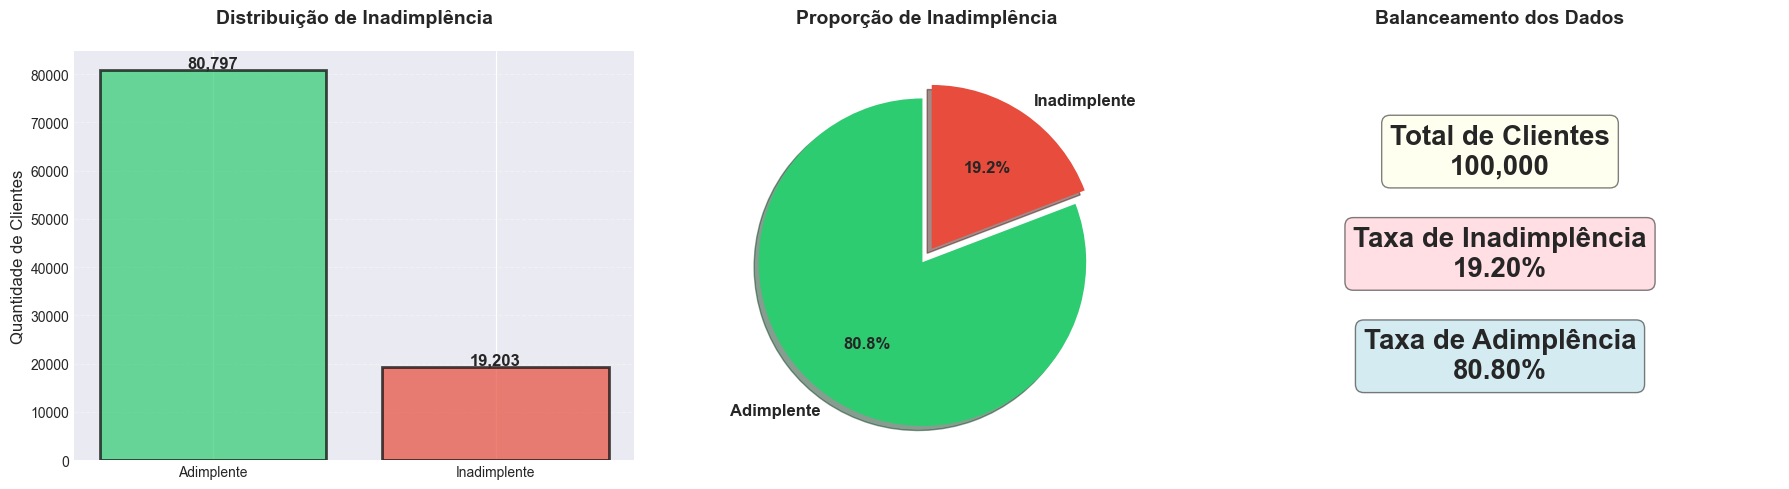

In [ ]:
# Visualização
ig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico 1: Barras
cores = ['#2ecc71', '#e74c3c']
bars = axes[0].bar(['Adimplente', 'Inadimplente'], distribuicao, 
                   color=cores, alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_title('Distribuição de Inadimplência', fontsize=14, fontweight='bold', pad=20)
axes[0].set_ylabel('Quantidade de Clientes', fontsize=12)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')
    

# Gráfico 2: Pizza
axes[1].pie(distribuicao, labels=['Adimplente', 'Inadimplente'],
           autopct='%1.1f%%', colors=cores,
           startangle=90, explode=[0.05, 0.05],
           textprops={'fontsize': 12, 'fontweight': 'bold'},
           shadow=True)
axes[1].set_title('Proporção de Inadimplência', fontsize=14, fontweight='bold', pad=20)


# Gráfico 3: Resumo
total = len(df)
inadim = distribuicao[1]
adim = distribuicao[0]
razao = inadim / adim

axes[2].text(0.5, 0.7, f'Total de Clientes\n{total:,}', 
            ha='center', fontsize=20, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))
axes[2].text(0.5, 0.45, f'Taxa de Inadimplência\n{inadim/total*100:.2f}%',
            ha='center', fontsize=20, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='pink', alpha=0.5))
axes[2].text(0.5, 0.20, f'Taxa de Adimplência\n{adim/total*100:.2f}%', 
             ha='center', fontsize=20, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

axes[2].set_xlim(0, 1)
axes[2].set_ylim(0, 1)
axes[2].axis('off')
axes[2].set_title('Balanceamento dos Dados', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()


📊 4. ANÁLISE UNIVARIADA - VARIÁVEIS CATEGÓRICAS

📌 VARIÁVEL: GENERO


,Frequência Absoluta,Percentual (%)
genero,,
F,52229,52.2%
M,47771,47.8%



📌 VARIÁVEL: ESTADO_CIVIL


,Frequência Absoluta,Percentual (%)
estado_civil,,
Casado,45068,45.1%
Solteiro,34995,35.0%
Divorciado,14888,14.9%
Viúvo,5049,5.0%



📌 VARIÁVEL: ESCOLARIDADE


,Frequência Absoluta,Percentual (%)
escolaridade,,
Médio,35102,35.1%
Superior,34929,34.9%
Fundamental,19945,19.9%
Pós-graduação,10024,10.0%



📌 VARIÁVEL: ESTADO


,Frequência Absoluta,Percentual (%)
estado,,
SP,25007,25.0%
RJ,14973,15.0%
MG,9923,9.9%
GO,9912,9.9%
RS,8160,8.2%
BA,8102,8.1%
PR,6980,7.0%
SC,6013,6.0%
PE,5893,5.9%



📌 VARIÁVEL: OCUPACAO


,Frequência Absoluta,Percentual (%)
ocupacao,,
CLT,60113,60.1%
Autônomo,25057,25.1%
Empresário,9864,9.9%
Desempregado,4966,5.0%


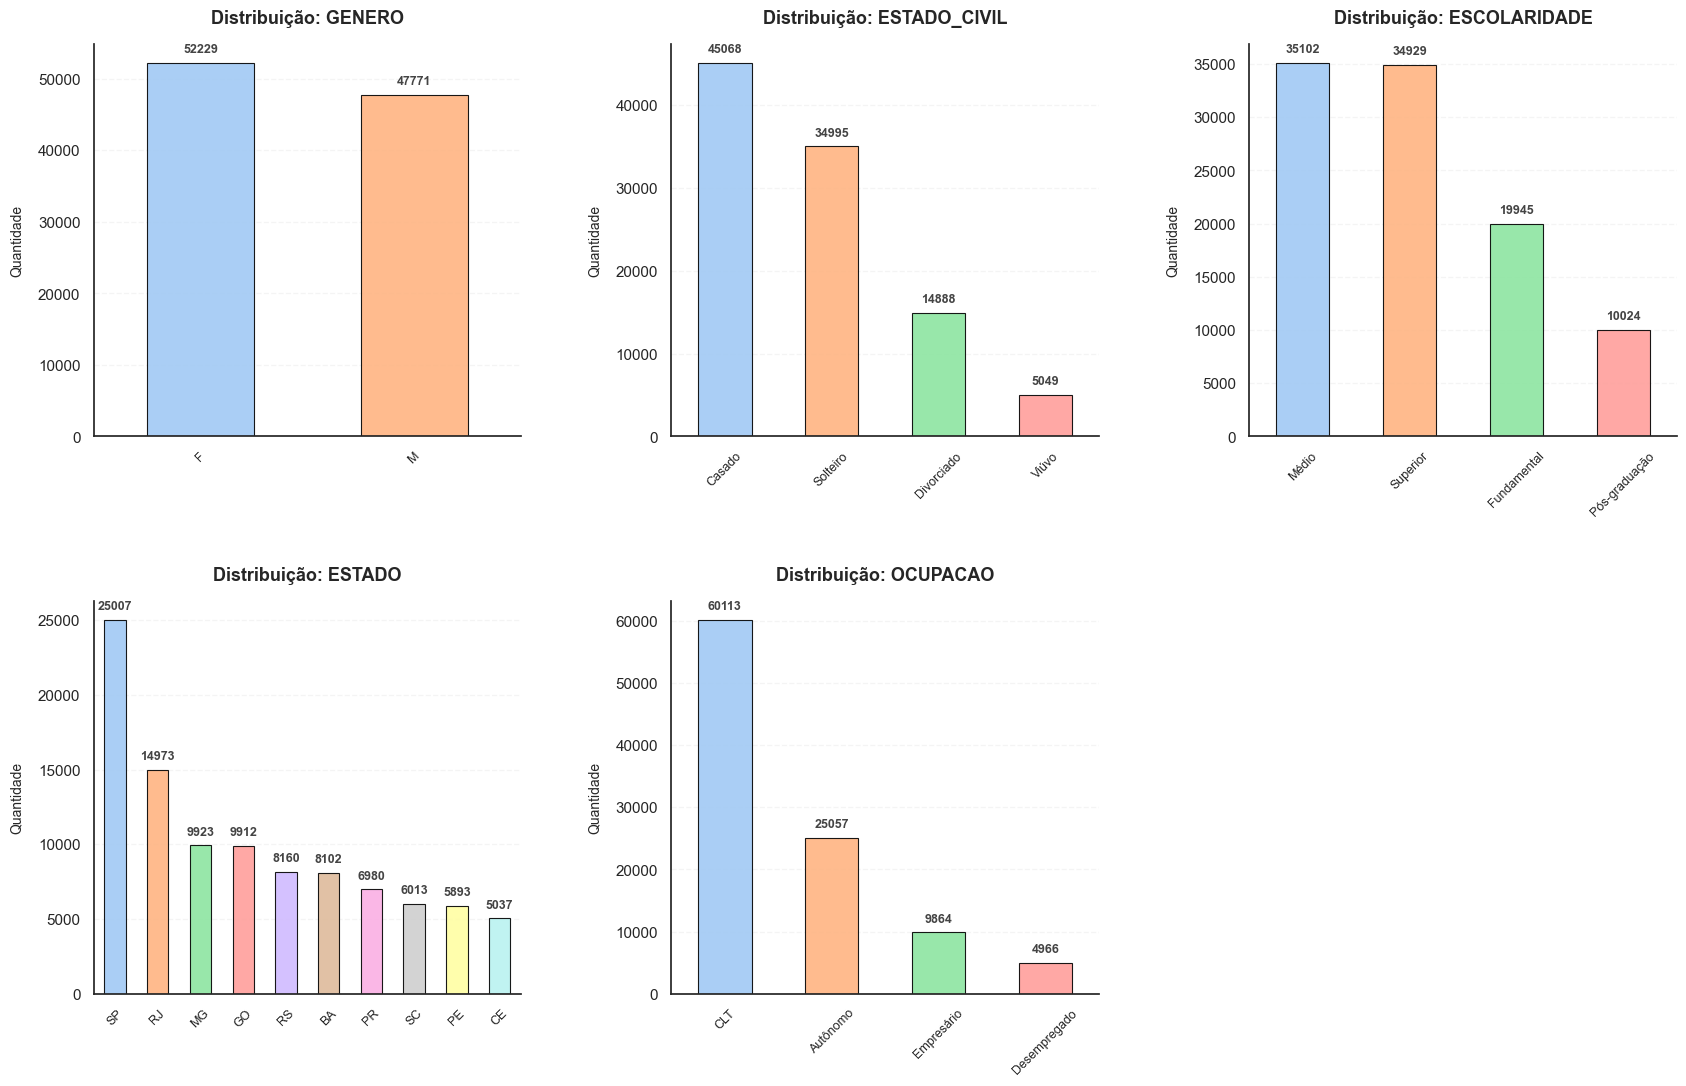

In [125]:
# Análise Univariada - CATEGÓRICAS
print("\n" + "="*80)
print("📊 4. ANÁLISE UNIVARIADA - VARIÁVEIS CATEGÓRICAS")
print("="*80)

# Lista de variáveis categóricas
cat_vars = ['genero', 'estado_civil', 'escolaridade', 'estado', 'ocupacao']

# Análise de cada variável
for var in cat_vars:
  print(f"\n📌 VARIÁVEL: {var.upper()}")
  contagem = df[var].value_counts()
  percentual = df[var].value_counts(normalize=True) * 100 

  resumo = pd.DataFrame({
    'Frequência Absoluta': contagem,
    'Percentual (%)': percentual
  })

  resumo['Percentual (%)'] = resumo['Percentual (%)'].map('{:.1f}%'.format)
    
  display(resumo)

# Visualização do gráfico
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

paleta = sns.color_palette("pastel")

for idx, var in enumerate(cat_vars):
  ax = axes[idx]
  contagem = df[var].value_counts()
  contagem.plot(kind='bar', ax=ax, 
                color=paleta[:len(contagem)], 
                edgecolor='black', 
                linewidth=0.8,
                alpha=0.9)
  ax.set_title(f'Distribuição: {var.upper()}', fontweight='bold', fontsize=13, pad=15)
  ax.set_xlabel('')
  ax.set_ylabel('Quantidade', fontsize=10, labelpad=10)
  ax.tick_params(axis='x', rotation=45, labelsize=9)
  ax.grid(axis='y', alpha=0.2, linestyle='--')
  sns.despine(ax=ax)
  offset = max(contagem) * 0.02
  
  for i, val in enumerate(contagem):
    ax.text(i, val + offset, f'{val}', ha='center', va='bottom', 
            fontsize=9, fontweight='bold', color='#444444')
    
for i in range(len(cat_vars), len(axes)):
    axes[i].axis('off')

plt.tight_layout(pad=4.0) 
plt.show()

In [ ]:
# Análise Univariada - NUMÉRICAS
print("\n" + "="*80)
print("📊 5. ANÁLISE UNIVARIADA - VARIÁVEIS NUMÉRICAS")
print("="*80)

num_vars = ['idade', 'renda_anual', 'valor_patrimonio', 'numero_dependentes',
            'tempo_emprego_atual', 'score_serasa_externo', 'utilizacao_limite_cartao',
            'historico_atraso_90_dias']

for var in num_vars:
  print(f"\n📌 VARIÁVEL: {var.upper()}")

  print(f"\n📊 Estatísticas:")
  print(f"Média: {df[var].mean():,.2f}")
  print(f"Mediana: {df[var].median():,.2f}")
  print(f"Desvio Padrão: {df[var].std():,.2f}")
  print(f"Mínimo: {df[var].min():,.2f}")
  print(f"Máximo: {df[var].max():,.2f}")
  print(f"Q1 (25%): {df[var].quantile(0.25):,.2f}")
  print(f"Q3 (75%): {df[var].quantile(0.75):,.2f}")

  # Detecta outliers (método IQR)
  Q1 = df[var].quantile(0.25)
  Q3 = df[var].quantile(0.75)
  IQR = Q3 - Q1
  outliers = ((df[var] < (Q1 - 1.5 * IQR)) | (df[var] > (Q3 + 1.5 * IQR))).sum()
  print(f"\n🔍 Outliers detectados: {outliers:,} ({outliers/len(df)*100:.2f}%)")

# Visualização do gráfico
fig, axes = plt.subplots(len(num_vars), 2, figsize=(16, 4*len(num_vars)))

for idx, var in enumerate(num_vars):
  # Histograma
  axes[idx, 0].hist(df[var], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
  axes[idx, 0].axvline(df[var].mean(), color='red', linestyle='--', linewidth=2, label=f'Média: {df[var].mean():.0f}')
  axes[idx, 0].axvline(df[var].median(), color='green', linestyle='--', linewidth=2, label=f'Mediana: {df[var].median():.0f}')
  axes[idx, 0].set_title(f'Histograma: {var.upper()}', fontweight='bold')
  axes[idx, 0].set_xlabel(var)
  axes[idx, 0].set_ylabel('Frequência')
  axes[idx, 0].legend()
  axes[idx, 0].grid(alpha=0.3, linestyle='--')

  # Boxplot
  box = axes[idx, 1].boxplot(df[var], vert=False, patch_artist=True,
                             boxprops=dict(facecolor='lightblue', alpha=0.7),
                             medianprops=dict(color='red', linewidht=2),
                             whiskerprops=dict(color='black', linewidht=1.5),
                             capprops=dict(color='black', linewidht=1.5))
  axes[idx, 1].set_title(f'Boxplot: {var.upper()}', fontweight='bold')
  axes[idx, 1].set_xlabel(var)
  axes[idx, 1].grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

In [ ]:
# Análise Bivariada - TARGET vs VAR CATEGÓRICAS
print("\n" + "="*80)
print("🎯 6. ANÁLISE BIVARIADA - INADIMPLÊNCIA vs CATEGÓRICAS")
print("="*80)

# Para cada var categórica, ver a taxa de inadimplência
for var in cat_vars:
  print(f"\n📌 TAXA DE INADIMPLÊNCIA POR: {var.upper()}")

  taxa_por_categoria = df.groupby(var)['inadimplente'].agg(['sum', 'count', 'mean'])
  taxa_por_categoria.columns = ['Inadimplentes', 'Total', 'Taxa']
  taxa_por_categoria['Taxa'] = taxa_por_categoria['Taxa'] * 100
  taxa_por_categoria = taxa_por_categoria.sort_values('Taxa', ascending=False)

  print(f"\n{taxa_por_categoria.to_string()}")

  # Identifica categoria de maior risco
  maior_risco = taxa_por_categoria.idxmax()['Taxa']
  menor_risco = taxa_por_categoria.idxmin()['Taxa']
  print(f"\n💡 Insights:")
  print(f"• Maior risco: {maior_risco} ({taxa_por_categoria.loc[maior_risco, 'Taxa']:.1f}%)")
  print(f"• Menor risco: {menor_risco} ({taxa_por_categoria.loc[menor_risco, 'Taxa']:.1f}%)")

  # Visualização comparativa
  fig, axes = plt.subplots(2, 3, figsize=(18,10))
  axes = axes.flatten()

  for idx, var in enumerate(cat_vars):
    taxa = df.groupby(var)['indadimplente'].mean().sort_values(ascending=False) * 100
    taxa.plot(kind='barh', ax=axes[idx], color='coral', edgecolor='black', alpha=0.8)
    axes[idx].set_title(f"Taxa de Inadimplência por {var.upper()}", fontweight='bold')
    axes[idx].set_xlabel("Taxa de Inadimplência (%)")
    axes[idx].grid(axis='x', alpha=0.3, linestyle='--')

    # Adiciona linha de referência
    taxa_geral = df['inadimplente'].mean() * 100
    axes[idx].axvline(taxa_geral, color='red', linestyle='--', linewidht=2,
                      label=f"Taxa Geral: {taxa_geral:.1f}%")
    axes[idx].legend()

axes[-1].axis('off')
plt.tight_layout()
plt.show()